#**Capstone project: Can ML Outperform Market-Neutral Trading in Structural Breaks?**

**Note:**

It's a good practise to "restart the session", whenever changes are made to the github repository


##**Step 1:** GitHub setup

1) Clone/Update the projects github repository

In [1]:
# Use for the first time to clone the github repo or when the repo is updated
%rm -rf /content/MarketNeutral_Trading_multiple_pairs/
%cd /content
!git clone https://github.com/WQU-Capstone-11205/MarketNeutral_Trading_multiple_pairs.git
%cd /content/MarketNeutral_Trading_multiple_pairs/

/content
Cloning into 'MarketNeutral_Trading_multiple_pairs'...
remote: Enumerating objects: 289, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 289 (delta 55), reused 21 (delta 21), pack-reused 208 (from 1)
Receiving objects: 100% (289/289), 1.31 MiB | 22.37 MiB/s, done.
Resolving deltas: 100% (140/140), done.
/content/MarketNeutral_Trading_multiple_pairs


2) Add the project's github repository's path to the system path

In [2]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/content/MarketNeutral_Trading_multiple_pairs')

3) Install projects required packages

In [3]:
!pip install -r requirements.txt

##**Step 2:** Data loading

- Load data and convert to distance spread

In [4]:
from util.ff_benchmark import get_ff_benchmark_returns
from data_loading.fetch_data import fetch_from_yfinance
from data_loading.PairsSpread import SP500PairSpread

start_date = '2015-01-01' #'2019-01-01' # '2005-01-01'
end_date = '2025-01-01' # '2024-01-01' # '2025-01-01'
in_sample_cutoff_date = '2022-01-01' # '2017-01-01' # After this date the cointegration fails

# Fetch a benchmark for alpha/beta calculation (e.g., SPY)
benchmark_data = fetch_from_yfinance(['SPY'], start_date, end_date)
benchmark_returns = benchmark_data.pct_change().dropna()
train_spy_returns = benchmark_returns.loc[:in_sample_cutoff_date]
test_spy_returns = benchmark_returns.loc[in_sample_cutoff_date:]
ff_benchmark_returns = get_ff_benchmark_returns(in_sample_cutoff_date, end_date)

selector = SP500PairSpread(
    selection_start=start_date,
    selection_end=end_date,
    method="distance",
    pairs_per_sector=4
)

spread = selector.distance_spread()

# price data used to compute cointegration
tickers = sorted(set(t for pair in spread.columns for t in pair.split("-")))
price_df = fetch_from_yfinance(tickers, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


Fetching SP500 pairs from Wikipedia...
Calculating spread...


[*********************100%***********************]  74 of 74 completed
[*********************100%***********************]  74 of 74 completed


**Report on pair characteristics:**

In [5]:
from metrics.ReportPairCharacteristics import ReportPairCharacteristics
from util.seed_random import seed_random

seed_random(42, device="cpu")

char_reporter = ReportPairCharacteristics(spread, price_df)
pair_chars = char_reporter.compute_characteristics()
dispersion = char_reporter.dispersion_summary()

print(pair_chars)
print("\nDispersion summary:")
print(dispersion)

train_spread = spread.loc[:in_sample_cutoff_date]
test_spread = spread.loc[in_sample_cutoff_date:]

spread_returns = spread.pct_change().dropna()
train_spread_returns = spread_returns.loc[:in_sample_cutoff_date]
test_spread_returns = spread_returns.loc[in_sample_cutoff_date:]

            coint_pvalue  norm_price_dist  spread_vol   half_life
pair                                                             
GOOG-GOOGL      0.000157         3.426332    0.969430   42.279908
T-VZ            0.725507         8.945323    2.038703  342.630873
PSKY-WBD        0.749633        10.619008    8.596933  178.058248
DIS-VZ          0.114963        10.643148   17.995968  103.967301
DUK-SRE         0.020013         4.796113    5.037835   63.754451
WEC-XEL         0.000387         4.831703    2.431615   28.036333
AEE-WEC         0.093783         4.897048    2.927988   55.404717
CMS-WEC         0.140981         4.912778    2.321742   71.322196
L-PRU           0.042122         5.059049    3.892672   61.390845
KEY-TFC         0.022785         5.627041    0.953198   58.005441
BEN-IVZ         0.021578         5.652671    3.442267  175.301876
CB-TRV          0.006426         5.693468    9.408086   60.746749
APA-SLB         0.009203         5.597418    4.250773   57.594403
EOG-XOM   

<Figure size 600x300 with 0 Axes>

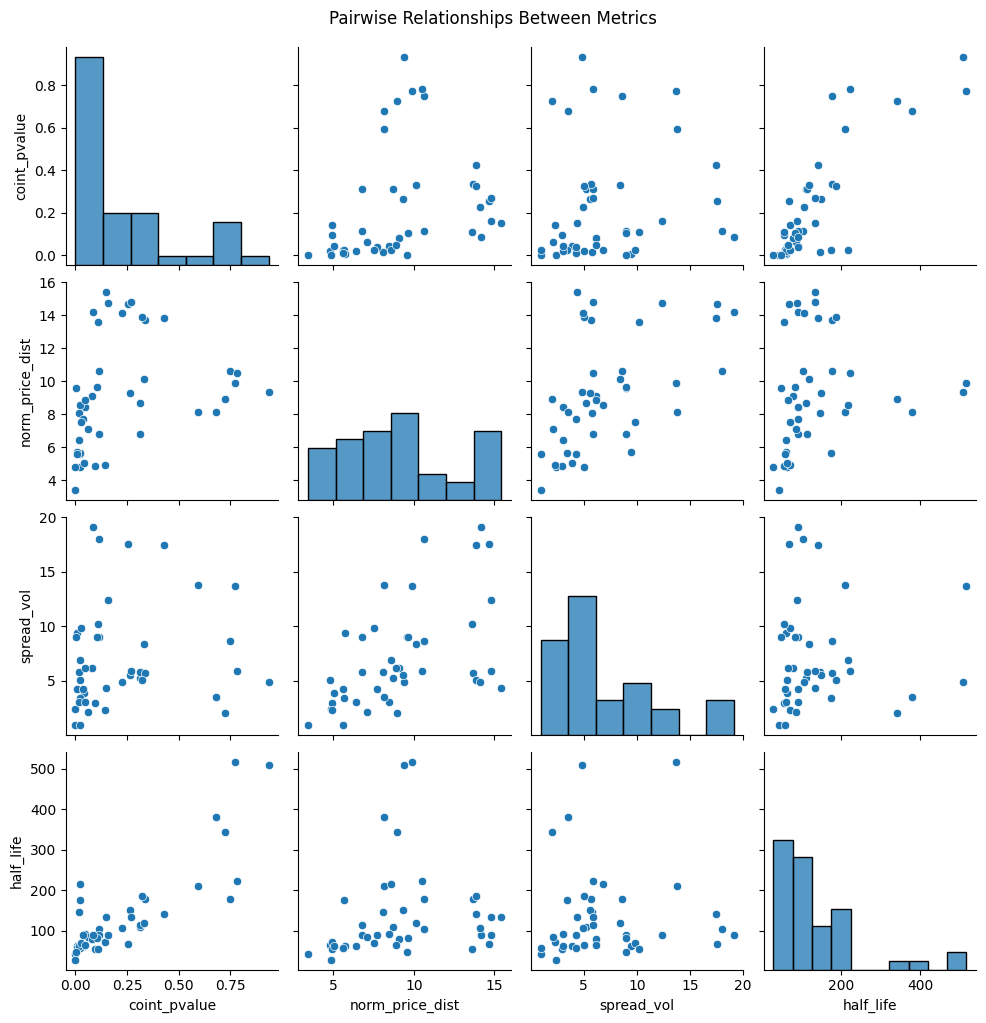

In [6]:
from plots.pairwiseplot import show_pairwise_relations
show_pairwise_relations(pair_chars)


**Inference:** The evaluated pairs span heterogeneous regimes in terms of cointegration, short-term similarity, volatility, and mean-reversion speed, providing a robust cross-section for performance analysis.

1) Cointegration p-value:
* Range: 0.0002 → 0.935
* Median: 0.11 → about half the pairs have strong cointegration (p < 0.2)
* 10th percentile: 0.0113 → some pairs are extremely stable
* 90th percentile: 0.712 → some pairs have weak or almost no cointegration

  Interpretation: The cross-section includes both stable and unstable cointegration pairs that shows good diversity along long-run equilibrium dimension.

2) Normalized price distance:
* Range: 3.43 → 15.43
* Median: 8.8
* 10th percentile: 4.96 → some pairs track very closely
* 90th percentile: 14.16 → some pairs are far apart in normalized price

  Interpretation: It shows short-term similarity differences, some pairs move very similarly, others are quite far apart. This combined with cointegration, ensures pairs have a mix of tight and loose spreads. It shows good diversity along short-term distance / co-movement.

3) Spread volatility:
* Range: 0.95 → 19.12
* Median: 5.75
* 10th percentile: 2.34 → very low-vol pairs
* 90th percentile: 13.75 → high-vol pairs

  Interpretation: The cross-section contains low-risk and high-risk pairs. Volatility heterogeneity complements cointegration heterogeneity. High-vol pairs may need wider z-score thresholds and low-vol pairs are slow-moving. It demonstrates good diversity along risk/volatility dimension.

4) Half-life:
* Range: 28 → 518 days
* Median: 90 → typical mean-reversion speed ~ 0.4 year
* 10th percentile: 56 → faster mean reversion
* 90th percentile: 221 → slow mean reversion
* Max: 518 → essentially non-mean-reverting

  Interpretation: The cross-section contains fast, moderate, and extremely slow mean-reverting pairs. Half-life and cointegration together show structural stability and trading horizon diversity. It shows strong diversity along speed of reversion/mean-reversion timescale.

5) Overall dispersion: All four metrics show wide spread across the cross-section. There are outliers, but that's fine it shows the strategy is tested across extreme scenarios. The pairs span a broad range of long-run stability, short-run co-movement, volatility, and mean-reversion speed.

**Report distributional results:**

In [7]:
from metrics.ReportDistributionalResults import ReportDistributionalResults

# initialize reporter
reporter = ReportDistributionalResults(test_spread, train_spread.mean(), train_spread.std())
# compute statistics
stats = reporter.distributional_stats()
# display results
for k, v in stats.items():
    print(f"{k:25s}: {v: .4f}")

median_performance       :  11.8180
p25_performance          :  6.0330
p75_performance          :  36.1740
interquartile_range      :  30.1410
worst_decile_drawdown    :  31.9061


**Conclusion:** While the median pair shows modest positive performance, there is substantial heterogeneity. The top-performing pairs outperform the median by approximately three times, and the worst-decile pairs experience large drawdowns. This underscores the importance of cross-sectional pair selection and risk management.

- Median Performance: The typical pair generates ~11.82 units of PnL (or return) in the test window. Median is robust to outliers, where most pairs are profitable, though not huge.
- 25th percentile: The lower quartile pair makes only 6.03 units, which are very low or near break-even. This indicates that some pairs perform poorly or marginally.
- 75th percentile: The upper quartile pair is doing very well around 36.17 units. This shows some pairs are much more profitable than the median.
- Interquartile range: It measures dispersion of performance.A wide IQR indicates large cross-sectional differences, which says some pairs are much stronger than others.
- Worst Decile Drawdown: The 10% worst-performing pairs experience a drawdown of ~31.9 units. This indicates significant downside risk for some pairs. It highlights the importance of pair selection or risk control.

Overall Interpretation:
- Median positive: most pairs generate profits
- Wide IQR: high dispersion across pairs; some pairs are much stronger than others.
- Significant worst-decile drawdown: risk is concentrated in poorly performing pairs.

In [8]:
spread.describe()

,GOOG-GOOGL,T-VZ,PSKY-WBD,DIS-VZ,DUK-SRE,WEC-XEL,AEE-WEC,CMS-WEC,L-PRU,KEY-TFC,...,MAR-TJX,ROST-YUM,IP-PPG,DD-IFF,DD-LYB,DD-IP,AKAM-CTSH,GLW-HPQ,NXPI-TEL,CSCO-TEL
count,2.516000e+03,2.516000e+03,2.516000e+03,2.516000e+03,2.516000e+03,2.516000e+03,2.516000e+03,2.516000e+03,2.516000e+03,2.516000e+03,...,2.516000e+03,2.516000e+03,2.516000e+03,2.516000e+03,2.516000e+03,2.516000e+03,2.516000e+03,2.516000e+03,2.516000e+03,2.516000e+03
mean,3.072617e-15,-7.681543e-16,-3.976328e-15,-6.868203e-15,1.784829e-15,-3.445398e-15,2.891875e-15,3.343731e-15,-2.417427e-15,8.585254e-16,...,-4.337813e-15,-6.325977e-15,3.795586e-15,-2.485205e-16,1.084453e-15,-2.349648e-15,7.952656e-15,-3.614844e-16,-1.879719e-14,-1.626680e-15
std,9.694302e-01,2.038703e+00,8.596933e+00,1.799597e+01,5.037835e+00,2.431615e+00,2.927988e+00,2.321742e+00,3.892672e+00,9.531979e-01,...,1.912126e+01,1.238783e+01,5.909368e+00,5.727516e+00,5.057851e+00,4.368341e+00,1.743953e+01,4.892569e+00,1.752172e+01,5.917277e+00
min,-1.712485e+00,-4.224774e+00,-2.636342e+01,-4.001604e+01,-1.246790e+01,-7.275956e+00,-1.380667e+01,-9.528147e+00,-1.020871e+01,-2.635638e+00,...,-5.471150e+01,-3.988773e+01,-1.691220e+01,-1.466173e+01,-1.259243e+01,-1.249591e+01,-4.001112e+01,-1.642848e+01,-3.510458e+01,-1.549966e+01
25%,-7.436477e-01,-1.831178e+00,-4.207367e+00,-1.109764e+01,-3.274816e+00,-1.556920e+00,-1.987013e+00,-1.800060e+00,-2.853094e+00,-8.157969e-01,...,-1.374194e+01,-6.377554e+00,-3.705339e+00,-3.752431e+00,-4.090510e+00,-3.104690e+00,-1.400587e+01,-3.223332e+00,-1.076490e+01,-3.448194e+00
50%,-9.814587e-02,2.373969e-01,-5.123899e-01,-3.251721e+00,6.095620e-01,-1.478261e-01,5.164399e-01,5.478885e-01,2.907694e-01,2.162332e-02,...,-1.488065e+00,1.740088e+00,-5.943355e-01,-5.889913e-01,-6.067345e-02,1.147446e+00,2.182016e+00,1.521502e+00,-5.676267e-01,-1.057445e+00
75%,5.214659e-01,1.533141e+00,3.867271e+00,8.234558e+00,2.727282e+00,9.559923e-01,2.422360e+00,1.624883e+00,2.906933e+00,6.733871e-01,...,1.020279e+01,7.964377e+00,4.196541e+00,4.094214e+00,4.015227e+00,3.537655e+00,1.100687e+01,3.403678e+00,7.084159e+00,2.646108e+00
max,5.442962e+00,5.704295e+00,2.330472e+01,6.339035e+01,1.449135e+01,1.455282e+01,5.545625e+00,6.387500e+00,1.328248e+01,2.666914e+00,...,5.548958e+01,2.631413e+01,1.964123e+01,1.456149e+01,1.117444e+01,7.781258e+00,4.616699e+01,9.211262e+00,6.785597e+01,1.641800e+01


##**Final Tuning:**

In [9]:
from tuning.BOCPD_tuner import BOCPD_tuner
from tuning.VAE_tuner import VAE_tuner
from tuning.RL_tuner import RL_tuner

default_bocpd_space = {
    "hazard": [5, 10, 15, 20, 50, 100, 250],
    "mu": [0, 1, 2],
    "kappa": [0.1, 0.3, 0.5, 1.0, 5.0, 10.0],
    "alpha": [0.1, 0.5, 1.0, 5.0, 10.0],
    "beta": [0.1, 0.3, 0.5, 0.8, 1.0, 5.0, 10.0]
}

default_vae_space = {
    "input_dim": [2],
    "latent_dim": [12],
    "hidden_dim": [32, 64, 128, 256],
    "lr": [1e-2, 1e-3, 1e-4],
    "vae_seq_len": [1, 5, 25],
    "kl_wt": [0.0005, 0.0001, 0.005, 0.001, 0.01]
}

default_rl_space = {
    "state_dim": [12],
    # "action_dim": [1],
    "hidden_dim": [64, 128, 256, 512],
    "actor_l2": [1e-6, 1e-5, 1e-4, 5e-4, 1e-3],
    "lr": [1e-4, 5e-5, 1e-5, 5e-6],
    "gamma": [0.95, 0.99, 1.0],
    "action_l2": [0.001, 0.01, 0.1, 0.2],
    "cp_weight": [0.05, 0.08, 0.10, 0.15, 0.2],
    "var_penalty": [1e-5, 5e-4, 1e-4, 5e-3],
    "var_window": [5, 10, 20, 50, 100],
    "dd_penalty": [0.001, 0.005, 0.01, 0.10, 0.25, 0.5],
    "dd_threshold": [0.05, 0.10, 0.2, 0.3, 0.5, 0.8],
    "actor_lr": [1e-3, 1e-4, 5e-5, 1e-5, 0],
    "tau": [0.001, 0.005, 0.05]
}

default_joint_space = {
    "state_window": [25, 50, 100],
    "base_action_sigma": [0.01, 0.1, 0.3],
    "wt_multplier": [1.5, 1.8, 2.0],
    "buffer_size_updates": [16, 64, 128, 256],
    "sample_batch_size": [8, 16, 64, 128],
    "transaction_cost": [0.001, 0.01, 0.1],
    "tc_scale": [0.2, 0.3, 0.5, 0.8, 1.0],
    "exploration_alpha": [2.0, 5.0, 6.5, 10.0],
    "update_every": [10, 20, 50]
}

bocpd_tuner = BOCPD_tuner(default_bocpd_space)
final_bocpd = bocpd_tuner.tune(spreads=train_spread)
print("BOCPD tuning complete: ")
print(final_bocpd)

vae_tuner = VAE_tuner(default_vae_space)
final_vae   = vae_tuner.tune(spreads=train_spread, bocpd_cfg=final_bocpd)
print("VAE tuning complete: ")
print(final_vae)

rl_tuner = RL_tuner(custom_rl_space=default_rl_space, custom_joint_space=default_joint_space)
final_rl, final_joint = rl_tuner.tune(
    spreads=train_spread,
    bocpd_cfg=final_bocpd,
    vae_cfg=final_vae
)
print("RL tuning complete: ")
print(final_rl)
print(final_joint)

BOCPD tuning: {'hazard': 100, 'mu': 0, 'kappa': 0.1, 'alpha': 1.0, 'beta': 0.3} :: 0.061
BOCPD tuning: {'hazard': 10, 'mu': 0, 'kappa': 10.0, 'alpha': 0.1, 'beta': 5.0} :: 0.07
BOCPD tuning: {'hazard': 100, 'mu': 2, 'kappa': 0.1, 'alpha': 10.0, 'beta': 0.8} :: 0.168
BOCPD tuning: {'hazard': 5, 'mu': 0, 'kappa': 0.1, 'alpha': 0.5, 'beta': 0.3} :: 0.1
BOCPD tuning: {'hazard': 50, 'mu': 2, 'kappa': 0.1, 'alpha': 10.0, 'beta': 0.3} :: 0.183
BOCPD tuning: {'hazard': 100, 'mu': 2, 'kappa': 10.0, 'alpha': 10.0, 'beta': 0.8} :: 0.197
BOCPD tuning: {'hazard': 10, 'mu': 1, 'kappa': 5.0, 'alpha': 1.0, 'beta': 10.0} :: 0.052
BOCPD tuning: {'hazard': 250, 'mu': 0, 'kappa': 0.3, 'alpha': 5.0, 'beta': 0.5} :: 0.103
BOCPD tuning: {'hazard': 15, 'mu': 0, 'kappa': 0.3, 'alpha': 1.0, 'beta': 0.1} :: 0.092
BOCPD tuning: {'hazard': 5, 'mu': 1, 'kappa': 0.1, 'alpha': 1.0, 'beta': 10.0} :: 0.1
BOCPD tuning: {'hazard': 15, 'mu': 2, 'kappa': 0.5, 'alpha': 0.1, 'beta': 5.0} :: 0.057
BOCPD tuning: {'hazard': 20,

##**Training:**

In [10]:
from train.train_loop_rl import train_loop_rl

train_loop_rl(
    spreads=train_spread,
    bocpd_params=final_bocpd,
    vae_params=final_vae,
    rl_params=final_rl,
    joint_params=final_joint,
    num_epochs=20
)

Epoch 000 | recon loss = 0.881 | kl loss = 0.007 | policy loss = 0.603 | Cumulative PnL = 696.369
Saved all models + optimizers
Saved best models at epoch 000 (Sharpe=0.127)
Epoch 001 | recon loss = 0.210 | kl loss = 0.013 | policy loss = 1.225 | Cumulative PnL = 712.168
No improvement. Early stopping patience counter = 1/5
Epoch 002 | recon loss = 0.028 | kl loss = 0.019 | policy loss = 1.514 | Cumulative PnL = 713.272
No improvement. Early stopping patience counter = 2/5
Epoch 003 | recon loss = 0.028 | kl loss = 0.019 | policy loss = 1.761 | Cumulative PnL = 713.464
No improvement. Early stopping patience counter = 3/5
Epoch 004 | recon loss = 0.028 | kl loss = 0.019 | policy loss = 1.859 | Cumulative PnL = 713.266
No improvement. Early stopping patience counter = 4/5
Epoch 005 | recon loss = 0.027 | kl loss = 0.019 | policy loss = 1.894 | Cumulative PnL = 712.978
No improvement. Early stopping patience counter = 5/5
EARLY STOPPING TRIGGERED at epoch 5
Multi-pair RL training stopped

In [11]:
from backtest.evaluate_loop_rl import evaluate_loop_rl

test_metrics, results = evaluate_loop_rl(
                    spreads=test_spread,
                    bocpd_params=final_bocpd,
                    vae_params=final_vae,
                    rl_params=final_rl,
                    joint_params=final_joint,
                    use_trained_rms=True
                )

Loaded models/opts
Evaluation loop: Sharpe Ratio = 0.038


##**Step 6:** Test metrics BOCPD+VAE+RL pipeline:

In [12]:
import numpy as np
from metrics.stats import sharpe_ratio, compute_max_drawdown, sortino_ratio, annual_volatility, alpha_beta

print("Test metrics for BOCPD+VAE+RL model:")
cum_pnl = np.cumsum(test_metrics['portfolio_pnl'])
print(f"Cummulative profit and loss                       : {cum_pnl[-1]:.6f}")
print(f"Sharpe Ratio                                      : {sharpe_ratio(test_metrics['portfolio_pnl']):.6f}")
print(f"Sortino ratio                                     : {sortino_ratio(test_metrics['portfolio_pnl']):.6f}")
print(f"Max drawdown                                      : {compute_max_drawdown(np.cumsum(test_metrics['portfolio_pnl'])):.6f}")
print(f"Annual Volatility                                 : {annual_volatility(test_metrics['portfolio_pnl']):.6f}")
alpha_ff, beta_ff = alpha_beta(test_metrics['portfolio_pnl'], ff_benchmark_returns)
print(f"Factor-adjusted Alpha-Beta                        : alpha = {alpha_ff:.6f} , beta = {beta_ff:.6f}")
alpha_spy, beta_spy = alpha_beta(test_metrics['portfolio_pnl'], test_spy_returns)
print(f"CAPM Alpha-Beta versus SPY                        : alpha = {alpha_spy:.6f} , beta = {beta_spy:.6f}")


Test metrics for BOCPD+VAE+RL model:
Cummulative profit and loss                       : 15.584613
Sharpe Ratio                                      : 0.038202
Sortino ratio                                     : 0.059780
Max drawdown                                      : 4.615327
Annual Volatility                                 : 136.707551
Factor-adjusted Alpha-Beta                        : alpha = 8.361194 , beta = -52.325422
CAPM Alpha-Beta versus SPY                        : alpha = 10.698322 , beta = -53.828659


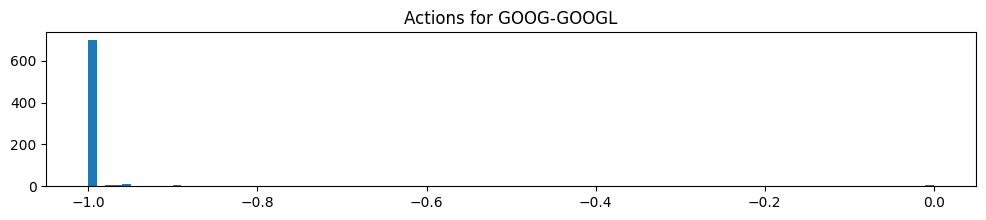

size of set = 471


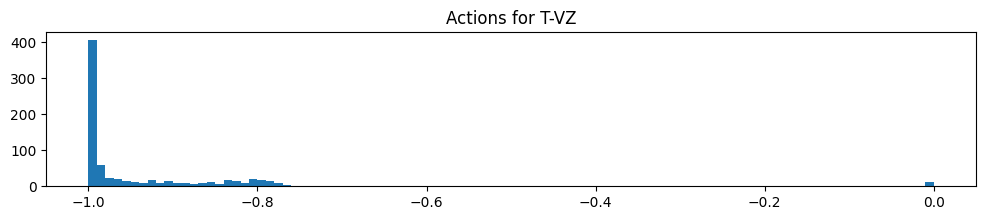

size of set = 634


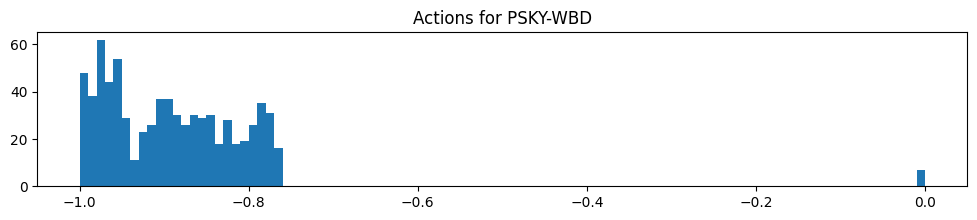

size of set = 745


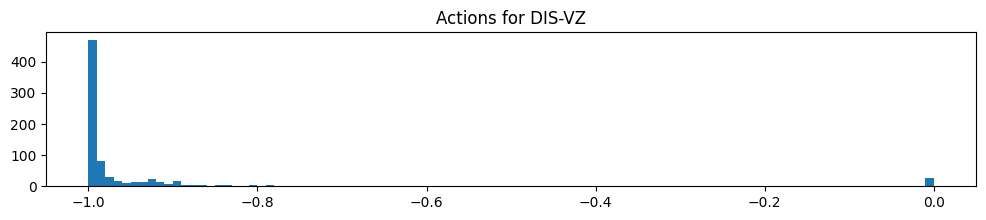

size of set = 632


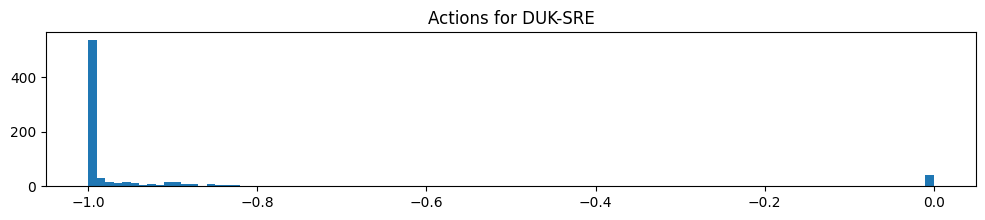

size of set = 524


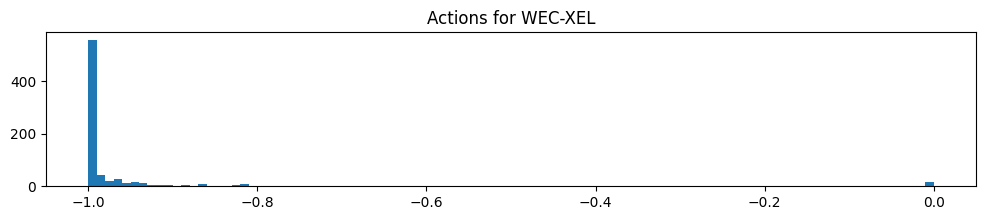

size of set = 497


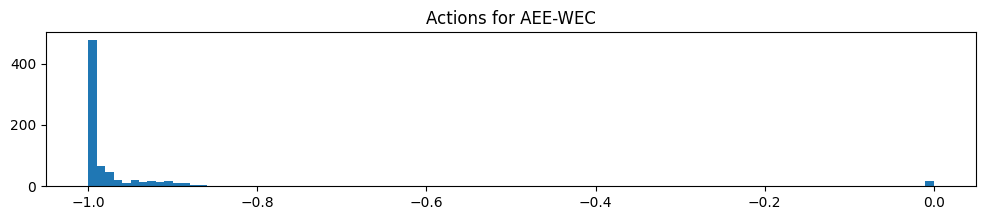

size of set = 646


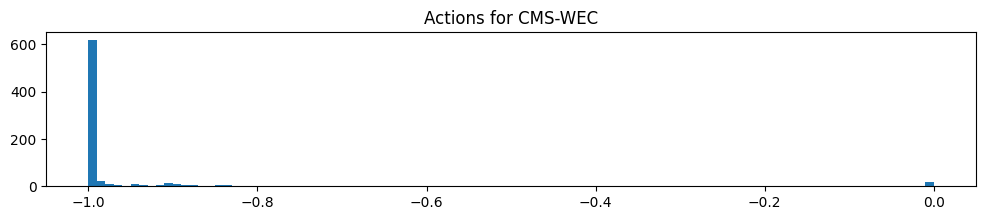

size of set = 471


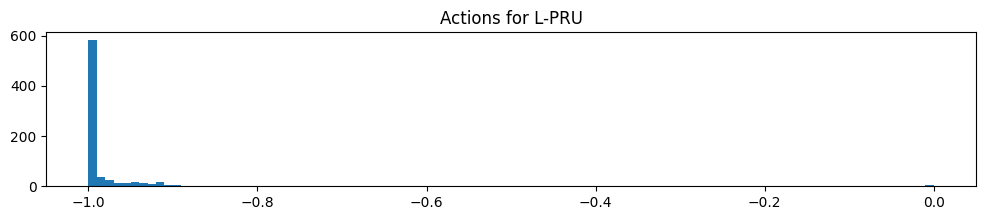

size of set = 583


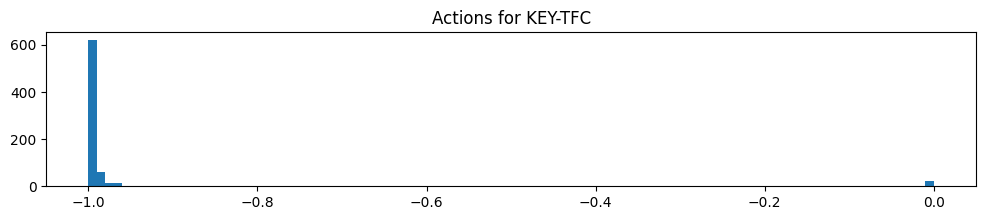

size of set = 459


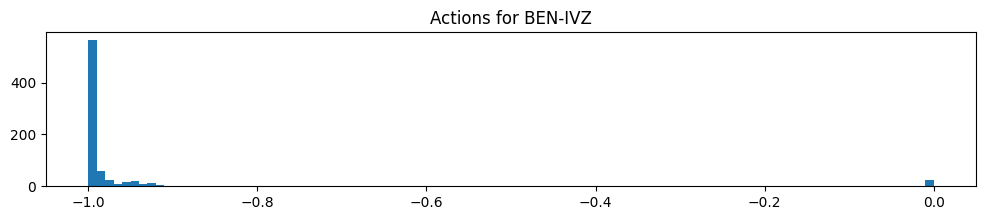

size of set = 509


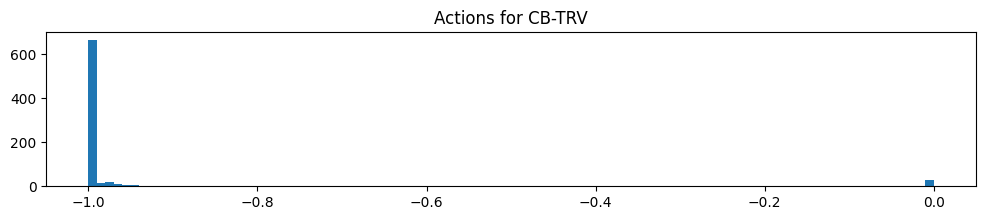

size of set = 301


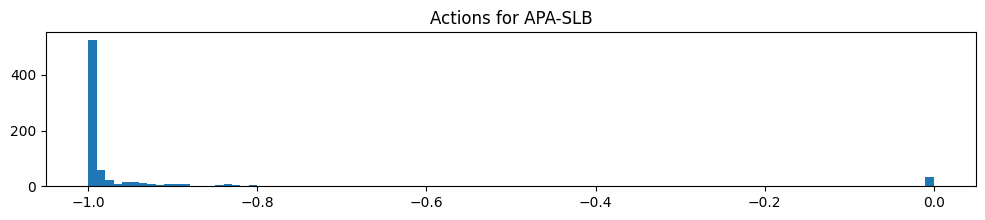

size of set = 475


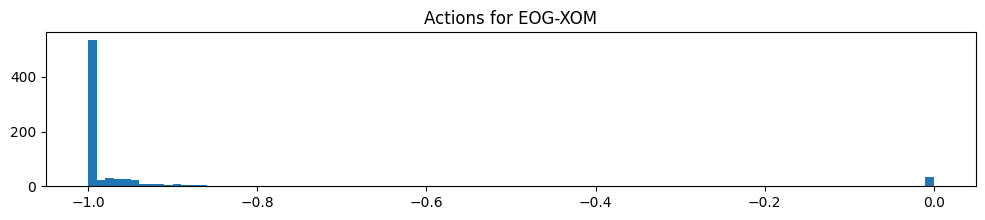

size of set = 501


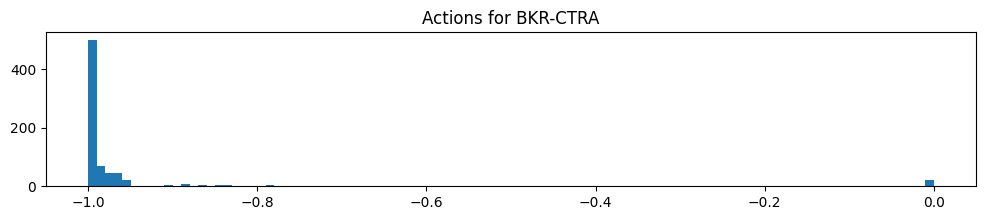

size of set = 637


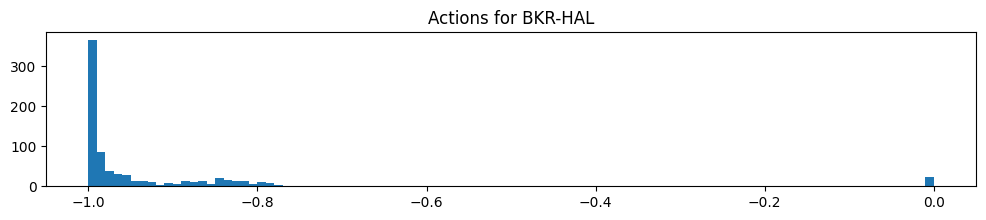

size of set = 635


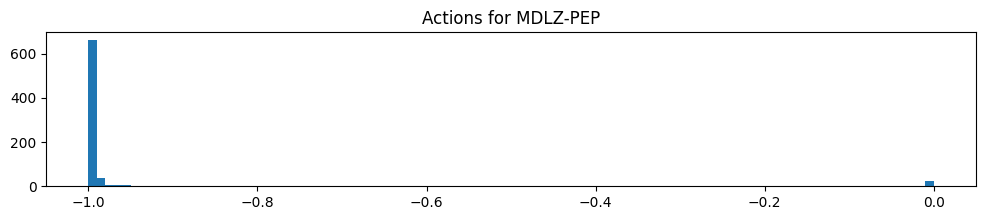

size of set = 443


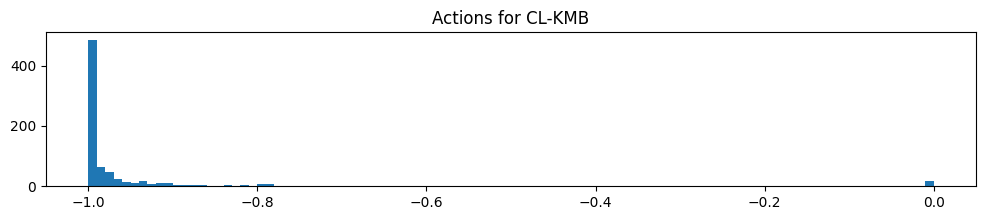

size of set = 514


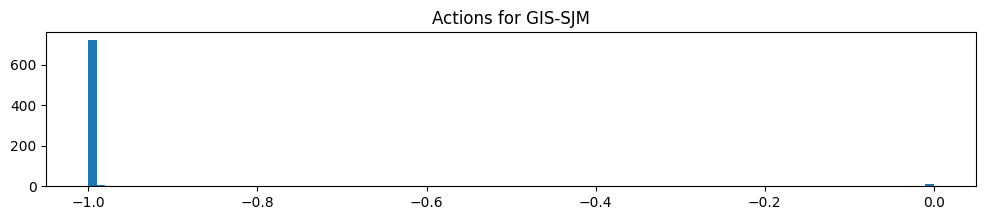

size of set = 201


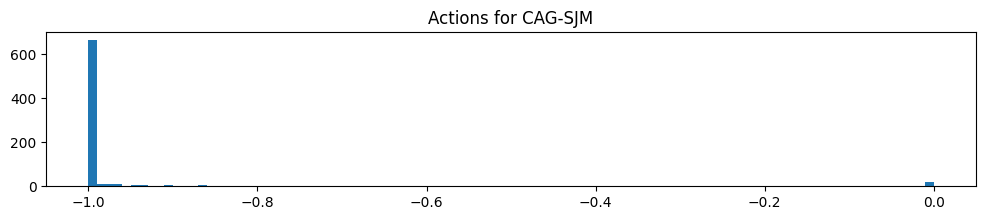

size of set = 469


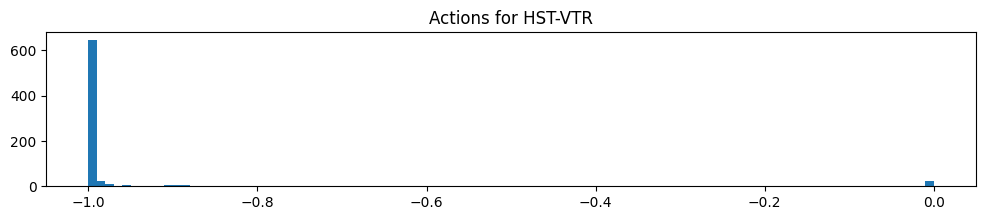

size of set = 527


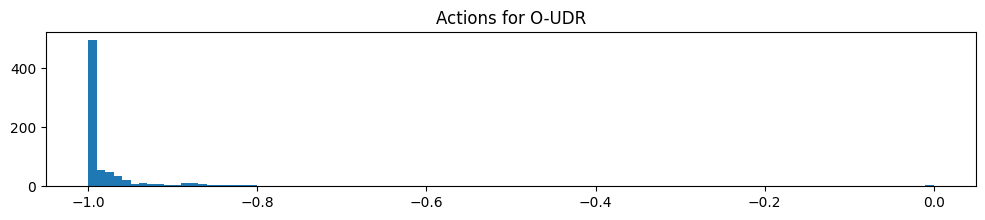

size of set = 622


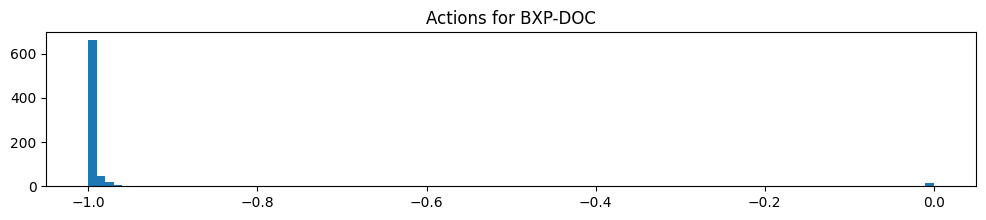

size of set = 550


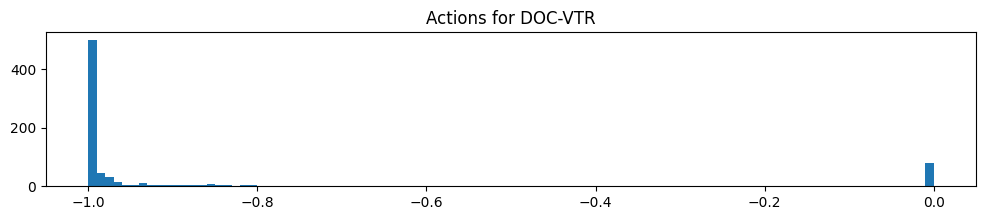

size of set = 513


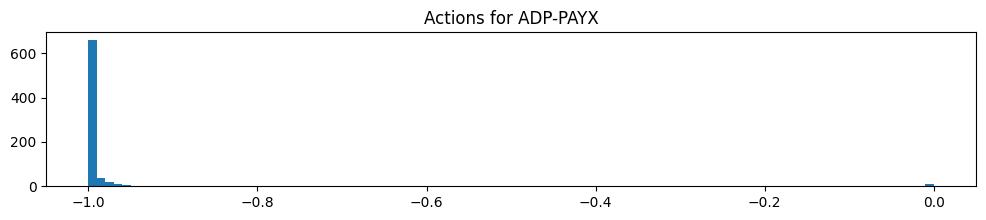

size of set = 408


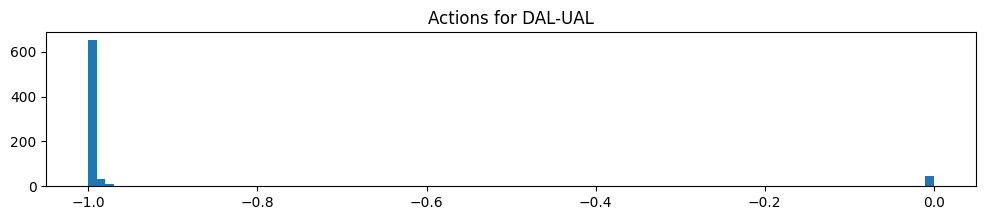

size of set = 472


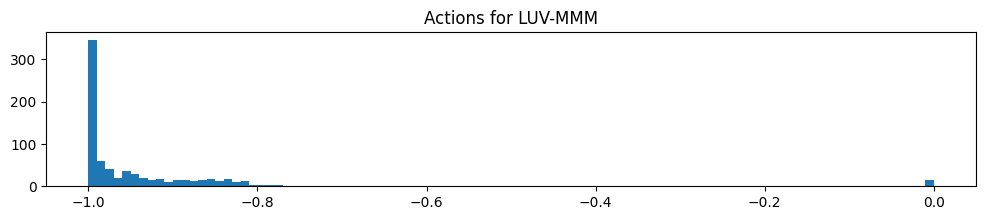

size of set = 599


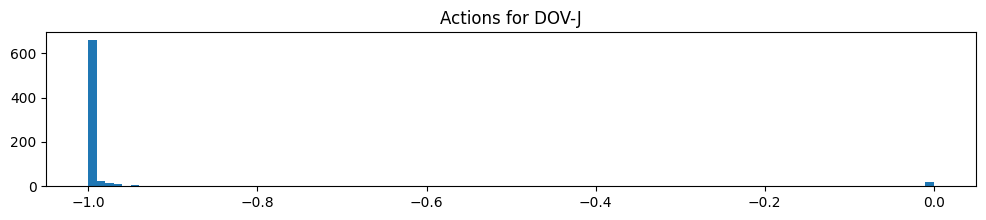

size of set = 283


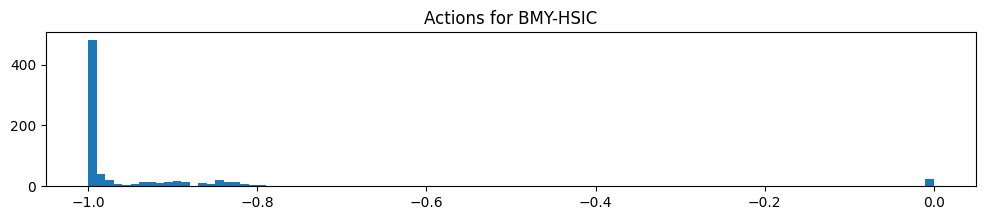

size of set = 587


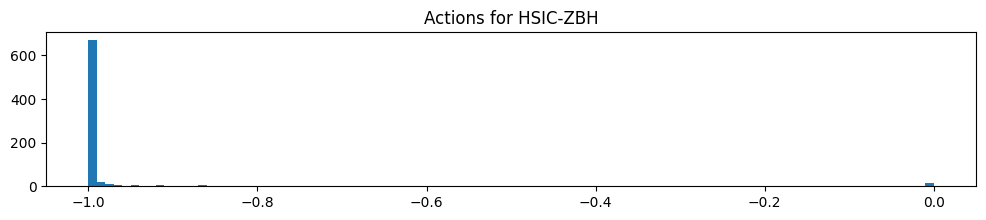

size of set = 426


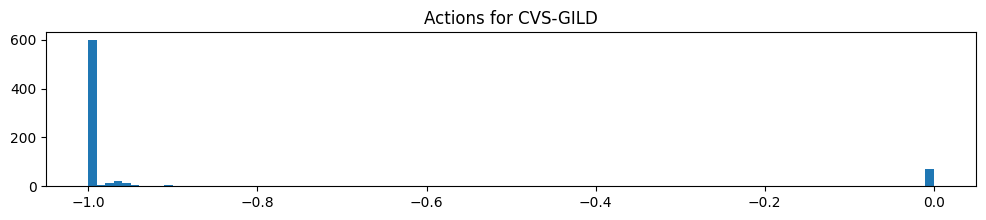

size of set = 282


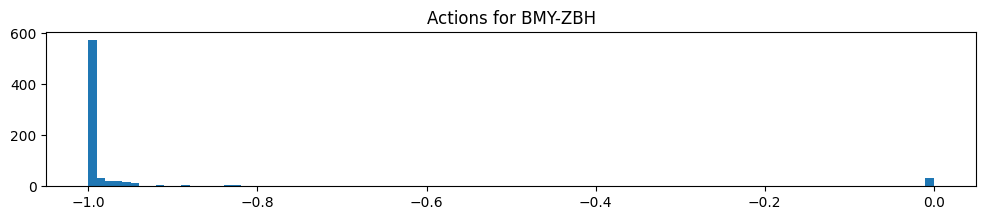

size of set = 402


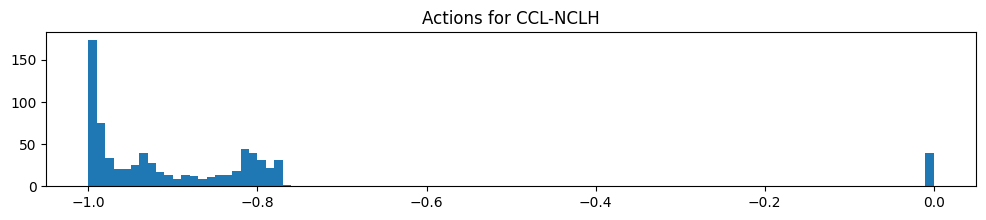

size of set = 714


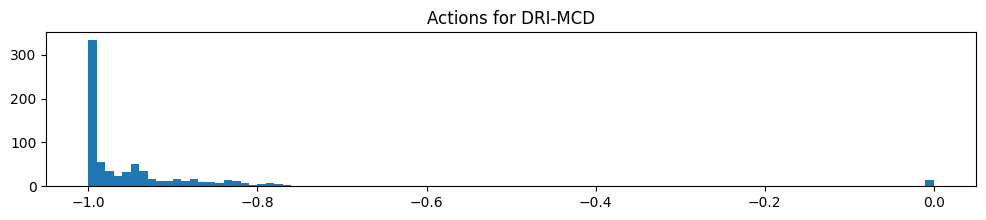

size of set = 717


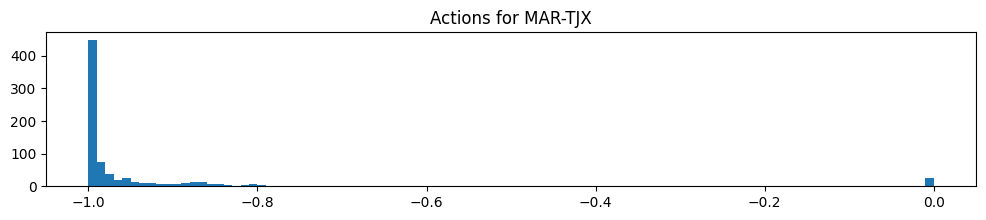

size of set = 657


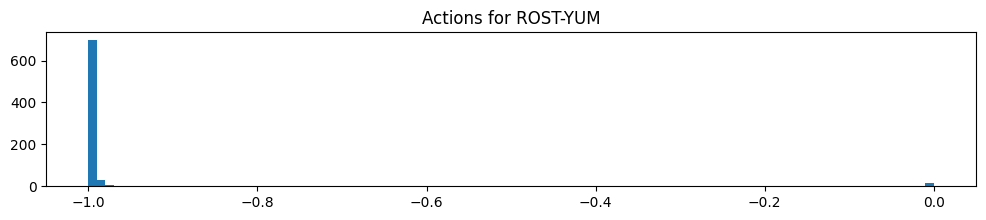

size of set = 316


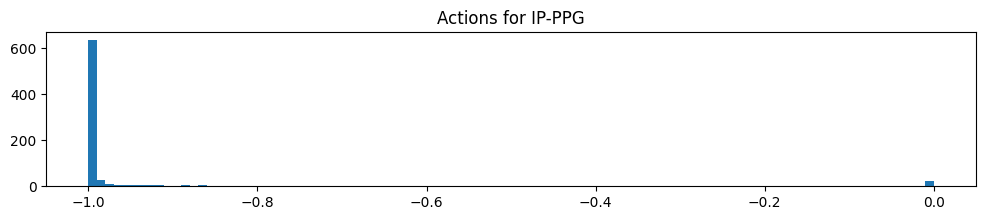

size of set = 372


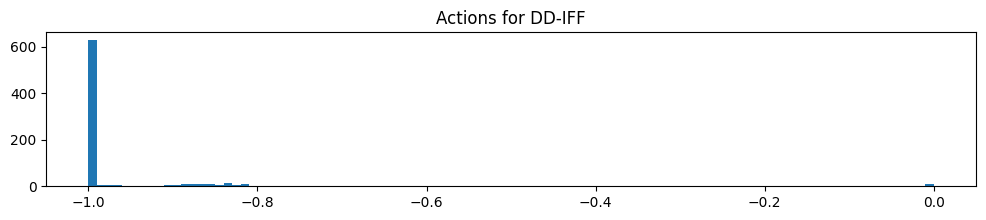

size of set = 330


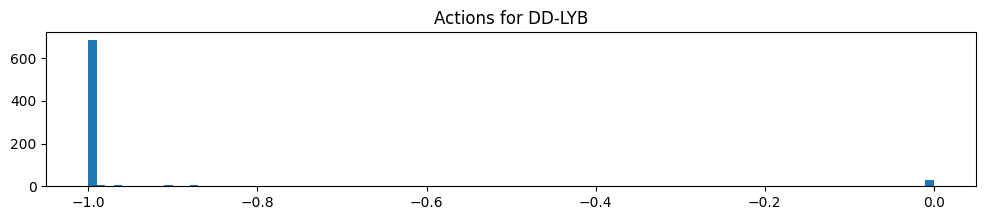

size of set = 169


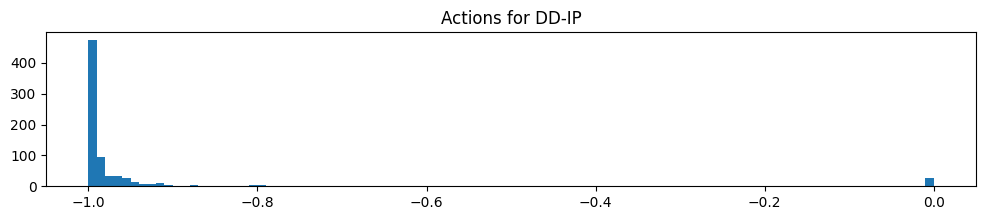

size of set = 630


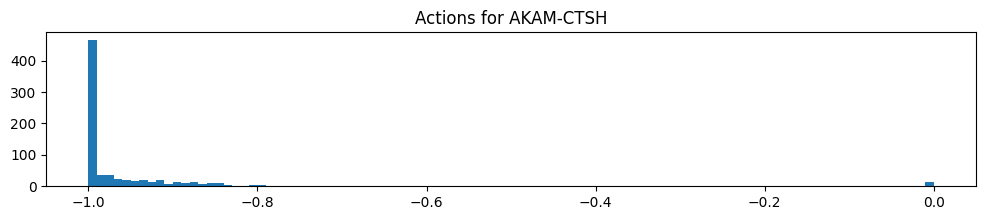

size of set = 717


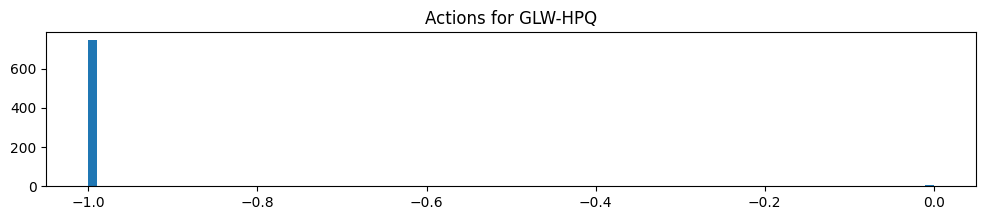

size of set = 59


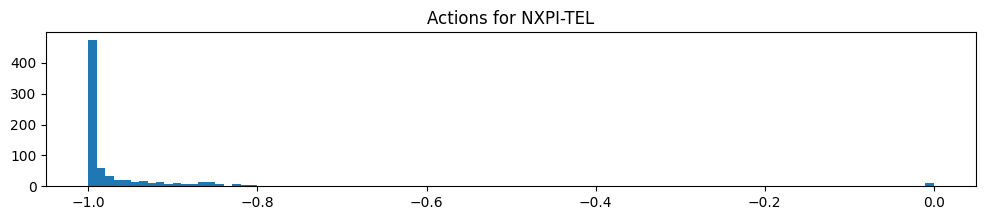

size of set = 425


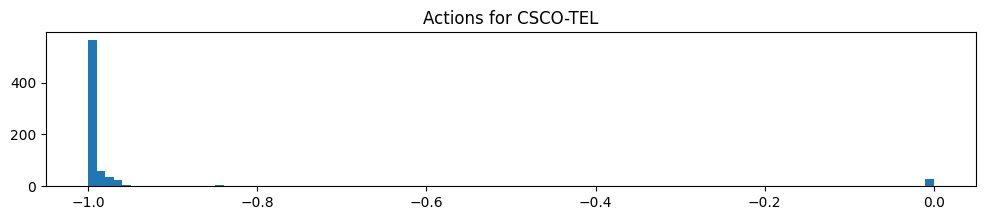

size of set = 589


In [13]:
import matplotlib.pyplot as plt

pairs = list(train_spread.keys())
for p in pairs:
    plt.figure(figsize=(12, 2))
    plt.hist(results[p]['position'], bins=100)
    unique_numbers = set(results[p]['position'])
    plt.title(f"Actions for {p}")
    plt.show()
    print(f'size of set = {len(unique_numbers)}')